# Cohort Analyses

## References

|Link|Notes|
|---|---|
|https://finance.yahoo.com/news/hell-coming-mathematical-proof-185019616.html|Basic spread models|
|https://www.insidermonkey.com/blog/donald-trump-has-3-3-percent-chance-of-dying-from-coronavirus-817781/|Basic risk mdoel|

## Imports and Setup

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
from ipypb import track
import datetime as dt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from celluloid import Camera
import os
import scipy.stats as stats
import time
from ipypb import track
import matplotlib as mpl
import git
import plotly.express as px
import plotly.graph_objects as go
import chaospy as cp
import scipy as sp

In [2]:
pd.options.display.max_columns = 999

## Data Update

In [3]:
nyt = git.cmd.Git("C:\\Users\\garfink2\\Documents\\data\\covid\\covid-19-data")
nyt.pull()
print(f"Data last updated {dt.datetime.now()}")

Data last updated 2020-05-10 20:23:25.413324


In [4]:
jhu = git.cmd.Git("C:\\Users\\garfink2\\Documents\\data\\covid\\COVID-19\\csse_covid_19_data\\csse_covid_19_daily_reports")
jhu.pull()
print(f"Data last updated {dt.datetime.now()}")

Data last updated 2020-05-10 20:23:27.610122


## Data

Data Sources (keep it simple and focus on building the models)
- https://covidtracking.com/api/
- New York Times

In [5]:
nytCountyData = "C:\\Users\\garfink2\\Documents\\data\\covid\\covid-19-data\\us-counties.csv"
folderOfJHUData = "C:\\Users\\garfink2\\Documents\\data\\covid\\COVID-19\\csse_covid_19_data\\csse_covid_19_daily_reports\\"
shp_USCounties = "C:\\Users\\garfink2\\Documents\\data\\basemap\\tl_2017_us_county\\tl_2017_us_county.shp"
shp_USStates = "C:\\Users\\garfink2\\Documents\\data\\basemap\\tl_2017_us_state\\tl_2017_us_state.shp"
excel_CountyPopulations = "C:\\Users\\garfink2\\Documents\\data\\basemap\\co-est2019-alldata.xlsx"

In [6]:
gdf_USCounties = gpd.read_file(shp_USCounties)
gdf_USStates = gpd.read_file(shp_USStates)

In [7]:
df_countyPouplations = pd.read_excel(excel_CountyPopulations)

## Add in population data to counties

In [8]:
fips = []
for i,row in df_countyPouplations.iterrows():
    fip = int(f"{row['STATE']}{str(row['COUNTY']).zfill(3)}")
    fips.append(fip)
df_countyPouplations["fips"] = fips

In [9]:
df_countyPouplations["fips"]

0        1000
1        1001
2        1003
3        1005
4        1007
        ...  
3188    56037
3189    56039
3190    56041
3191    56043
3192    56045
Name: fips, Length: 3193, dtype: int64

In [10]:
gdf_USCounties = gdf_USCounties[["STATEFP","COUNTYFP","GEOID","NAME","NAMELSAD","geometry"]]

In [11]:
gdf_USCounties["GEOID"] = gdf_USCounties["GEOID"].astype("int")

In [12]:
len(fips)

3193

In [13]:
len(list(gdf_USCounties["GEOID"]))

3233

In [14]:
gdf_USCounties.sort_values("GEOID").head()

,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,geometry
1328,01,001,1001,Autauga,Autauga County,"POLYGON ((-86.90310 32.54063, -86.90311 32.540..."
1246,01,003,1003,Baldwin,Baldwin County,"POLYGON ((-87.99068 30.55549, -87.99051 30.560..."
1827,01,005,1005,Barbour,Barbour County,"POLYGON ((-85.42982 32.04598, -85.42985 32.046..."
3014,01,007,1007,Bibb,Bibb County,"POLYGON ((-87.31226 33.08622, -87.31218 33.087..."
855,01,009,1009,Blount,Blount County,"POLYGON ((-86.74919 33.99760, -86.74902 33.997..."


In [15]:
gdf_USCounties = pd.merge(left=gdf_USCounties,right=df_countyPouplations,left_on="GEOID",right_on="fips")

In [16]:
gdf_USCounties = gdf_USCounties[["STATEFP","COUNTYFP","GEOID","NAME","NAMELSAD","geometry","POPESTIMATE2019"]]

In [17]:
len(df_countyPouplations)

3193

In [18]:
len(gdf_USCounties)

3142

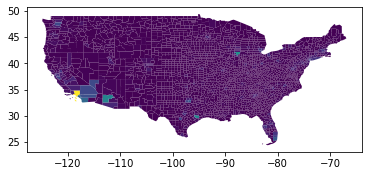

In [19]:
gdf_USCounties.cx[-125:-50, 20:70].plot("POPESTIMATE2019")

## Load the NYT Data

KLUDGE- create custom fips for New York City and Kansas City

In [20]:
df_nytCountyData = pd.read_csv(nytCountyData)

In [21]:
nycGeometry = gdf_USCounties[gdf_USCounties["GEOID"] == 36047].geometry.iloc[0]

In [22]:
kcGeometry = gdf_USCounties[gdf_USCounties["GEOID"] == 29095].geometry.iloc[0]

In [23]:
df_nytCountyData.loc[(df_nytCountyData.county=="New York City"),"fips"]=36047

In [24]:
df_nytCountyData.loc[(df_nytCountyData.county=="Kansas City"),"fips"]=29095

In [25]:
df_nytCountyData = df_nytCountyData.dropna(subset=["fips"])

In [26]:
df_nytCountyData["fips"] = df_nytCountyData["fips"].astype("int")

In [27]:
df_nytCountyData.sort_values("deaths",ascending=False)

,date,county,state,fips,cases,deaths
128553,2020-05-09,New York City,New York,36047,188663,19324
125642,2020-05-08,New York City,New York,36047,187157,19210
122736,2020-05-07,New York City,New York,36047,185653,19141
119837,2020-05-06,New York City,New York,36047,183770,18993
116954,2020-05-05,New York City,New York,36047,182318,18719
...,...,...,...,...,...,...
45985,2020-04-10,Clear Creek,Colorado,8019,11,0
45981,2020-04-10,Baca,Colorado,8009,9,0
45980,2020-04-10,Archuleta,Colorado,8007,6,0
45973,2020-04-10,Tuolumne,California,6109,1,0


In [28]:
gdf_countyTimeSeries = gpd.GeoDataFrame(pd.merge(left=df_nytCountyData,right=gdf_USCounties,left_on="fips",right_on="GEOID"))

In [29]:
gdf_countyTimeSeries['date'] = pd.to_datetime(gdf_countyTimeSeries['date'], errors='coerce')

In [30]:
# overwrite the FIPS again now that its merged
gdf_countyTimeSeries.loc[(gdf_countyTimeSeries.county=="New York City"),"fips"]=360470
gdf_countyTimeSeries.loc[(gdf_countyTimeSeries.county=="Kansas City"),"fips"]=290950

In [31]:
gdf_countyTimeSeries.loc[(gdf_countyTimeSeries.county=="New York City"),"geometry"]=nycGeometry
gdf_countyTimeSeries.loc[(gdf_countyTimeSeries.county=="Kansas City"),"geometry"]=kcGeometry

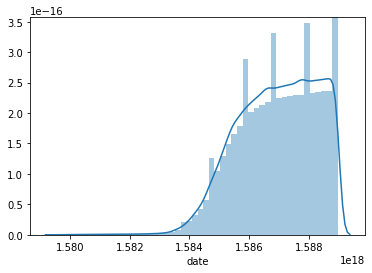

In [32]:
sns.distplot(gdf_countyTimeSeries["date"])

In [33]:
gdf_countyTimeSeriesDiff = gdf_countyTimeSeries.copy(deep=True)

In [34]:
gdf_countyTimeSeriesDiff["new cases"] = gdf_countyTimeSeriesDiff.groupby("fips")[["cases"]].diff().fillna(0)
gdf_countyTimeSeriesDiff["new deaths"] = gdf_countyTimeSeriesDiff.groupby("fips")[["deaths"]].diff().fillna(0)

In [35]:
gdf_countyTimeSeriesDiff[gdf_countyTimeSeriesDiff["date"] == dt.datetime(month=4,day=6,year=2020)].sort_values("new cases",ascending=False)

,date,county,state,fips,cases,deaths,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,geometry,POPESTIMATE2019,new cases,new deaths
2184,2020-04-06,New York City,New York,360470,73553,4857,36,047,36047,Kings,Kings County,"POLYGON ((-74.05647 40.63171, -74.05626 40.637...",2559903,4827.0,1211.0
7324,2020-04-06,Suffolk,New York,36103,14473,237,36,103,36103,Suffolk,Suffolk County,"POLYGON ((-72.86371 41.11338, -72.86351 41.113...",1476601,1540.0,62.0
3530,2020-04-06,Nassau,New York,36059,15616,535,36,059,36059,Nassau,Nassau County,"POLYGON ((-73.69445 40.90305, -73.62815 40.941...",1356924,1218.0,139.0
9980,2020-04-06,Wayne,Michigan,26163,8270,346,26,163,26163,Wayne,Wayne County,"POLYGON ((-83.28780 42.44268, -83.28764 42.442...",1749343,752.0,53.0
183,2020-04-06,Cook,Illinois,17031,8728,209,17,031,17031,Cook,Cook County,"POLYGON ((-88.23798 42.06693, -88.23797 42.066...",5150233,685.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5415,2020-04-06,Madera,California,6039,28,2,06,039,6039,Madera,Madera County,"POLYGON ((-120.10639 37.16715, -120.10577 37.1...",157327,-2.0,0.0
79743,2020-04-06,Ohio,West Virginia,54069,15,0,54,069,54069,Ohio,Ohio County,"POLYGON ((-80.62760 40.02517, -80.62770 40.025...",41411,-3.0,0.0
97880,2020-04-06,Mifflin,Pennsylvania,42087,5,0,42,087,42087,Mifflin,Mifflin County,"POLYGON ((-77.78773 40.61208, -77.78753 40.612...",46138,-4.0,0.0
72843,2020-04-06,Decatur,Georgia,13087,13,0,13,087,13087,Decatur,Decatur County,"POLYGON ((-84.85956 30.75303, -84.85962 30.753...",26404,-4.0,0.0


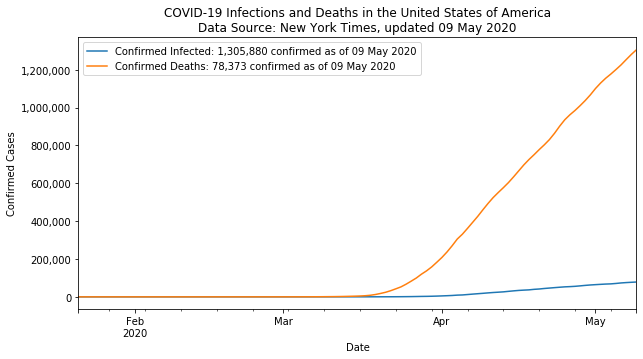

In [107]:
fig,ax = plt.subplots(figsize=(10,5))
gdf_countyTimeSeriesDiff.groupby("date").sum()["deaths"].plot(ax=ax,label=f"Confirmed Infected: {gdf_countyTimeSeriesDiff.groupby('date').sum()['cases'][-1]:,} confirmed as of {gdf_countyTimeSeriesDiff['date'].iloc[-1].strftime('%d %B %Y')}")
gdf_countyTimeSeriesDiff.groupby("date").sum()["cases"].plot(ax=ax,label=f"Confirmed Deaths: {gdf_countyTimeSeriesDiff.groupby('date').sum()['deaths'][-1]:,} confirmed as of {gdf_countyTimeSeriesDiff['date'].iloc[-1].strftime('%d %B %Y')}")
ax.legend()
ax.set_title(f"COVID-19 Infections and Deaths in the United States of America\nData Source: New York Times, updated {gdf_countyTimeSeriesDiff['date'].iloc[-1].strftime('%d %B %Y')}")
ax.set_xlabel("Date")
ax.set_ylabel("Confirmed Cases")
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) # https://stackoverflow.com/questions/25973581/how-do-i-format-axis-number-format-to-thousands-with-a-comma-in-matplotlib

### Plotly Express

In [37]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv')

In [ ]:
df

In [ ]:
simpleRollup = gdf_countyTimeSeriesDiff.groupby("date").sum().reset_index()

In [ ]:
simpleRollup.date=simpleRollup.date.apply(lambda x: x.strftime('%Y-%m-%d'))

In [ ]:
px.line(simpleRollup,y="cases",animation_frame="date",range_y=[0,1200000],range_x=[simpleRollup.date[0],simpleRollup.date[len(simpleRollup.date)-1]])

In [ ]:
px.scatter(simpleRollup,x=simpleRollup.index,y="cases",animation_frame=simpleRollup.index,range_y=[0,1200000],range_x=[simpleRollup.index[0],simpleRollup.index[-1]])

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(simpleRollup,x=simpleRollup.index,y="cases",animation_frame=simpleRollup.index,range_y=[0,1200000],range_x=[simpleRollup.index[0],simpleRollup.index[-1]]))

# try manual

In [ ]:
rollup = gdf_countyTimeSeriesDiff.groupby(["state","date"]).sum()
rollup = rollup.unstack(['state']).fillna(0).stack(['state']) # https://stackoverflow.com/questions/17287933/filling-in-date-gaps-in-multiindex-pandas-dataframe
rollup = rollup.reset_index()
rollup.date = rollup.date.apply(lambda x: x.strftime('%Y-%m-%d'))

In [ ]:
rollup["Deaths: Log Base 10"] = np.log10(rollup["deaths"])
rollup["Cases: Log Base 10"] = np.log10(rollup["cases"])

In [ ]:
# this works!
px.bar(rollup,x="state",y="Cases: Log Base 10",animation_frame="date",color="state",range_y=[0,10])

In [ ]:
spatialRollup = gdf_countyTimeSeriesDiff.groupby(["state","date"]).sum()
spatialRollup = spatialRollup.unstack(['state']).fillna(0).stack(['state']) # https://stackoverflow.com/questions/17287933/filling-in-date-gaps-in-multiindex-pandas-dataframe
spatialRollup = spatialRollup.reset_index()
# spatialRollup.index = spatialRollup["state"]
spatialRollup.date = spatialRollup.date.apply(lambda x: x.strftime('%Y-%m-%d'))

In [ ]:
spatialRollup = pd.merge(left=spatialRollup,right=gdf_USStates,left_on="state",right_on="NAME")

In [ ]:
spatialRollup = gpd.GeoDataFrame(spatialRollup)

In [ ]:
spatialRollup = spatialRollup.cx[-125:-50, 20:60]

In [ ]:
spatialRollup.head()

In [ ]:
fig = px.choropleth(spatialRollup, locations=spatialRollup["STUSPS"], color="deaths", hover_name="state", animation_frame="date", range_color=[0,100000])
fig.show()

In [ ]:
df.head()

In [ ]:
df = px.data.gapminder()
fig = px.choropleth(df, locations="iso_alpha", color="lifeExp", hover_name="country", animation_frame="year", range_color=[20,80])
fig.show()

In [ ]:
# this works!
px.bar(rollup,x="state",y="cases",animation_frame="date",color="state",range_y=[0,1300000],log_y=True)

In [ ]:
px.bar(rollup,x="state",y="deaths",animation_group="state",animation_frame="date",color="state",range_y=[0,100000],range_x=["2020-01-01","2020-05-03"])

In [ ]:
rollup[rollup["date"]=="2020-01-30"]

In [ ]:
rollup = gdf_countyTimeSeriesDiff.groupby(["state","date"]).sum().reset_index()
rollup.date = rollup.date.apply(lambda x: x.strftime('%Y-%m-%d'))

In [ ]:
rollup = gdf_countyTimeSeriesDiff.groupby(["state","date"]).sum()

In [ ]:
dates = sorted(list(set(rollup.date)))

In [ ]:
for date in dates:
    rollupSubset = rollup[rollup["date"]==date]

In [ ]:
rollupSubset

In [ ]:
rollup = gdf_countyTimeSeriesDiff.groupby(["state","date"]).sum().reset_index()
rollup.date = rollup.date.apply(lambda x: x.strftime('%Y-%m-%d'))

In [ ]:
rollup = rollup.sort_values("date")

In [ ]:
order = sorted(list(set(rollup["date"])))

In [ ]:
px.bar(rollup,x="state",y="deaths",animation_group="state",animation_frame="date",color="state",range_y=[0,100000],range_x=["2020-01-01","2020-05-03"])

In [ ]:
fig = px.line(simpleRollup, x='date', y='cases',animation_frame="date",range_y=[0,1000000],range_x=["2020-01-01","2020-05-03"])
fig.show()

In [ ]:
rollup

In [ ]:
px.scatter(rollup,x="cases",y="deaths",animation_group="state",animation_frame="date",color="state",range_x=[0,1300000],range_y=[0,100000])

In [ ]:
px.line(rollup,x="date",y="deaths",animation_group="state",animation_frame="date",color="state",range_x=['2020-01-21T00:00:00.000000000','2020-05-03T00:00:00.000000000'],range_y=[0,100000])

In [ ]:
gdf_countyTimeSeriesDiff.date.unique()

In [ ]:
fig = px.line(rollup, x=rollup.index, y='deaths',animation_frame=rollup.index,range_y=[0,100000],range_x=[rollup.index[0],rollup.index[-1]])
fig.show()

In [ ]:
df = px.data.gapminder()

fig = px.bar(df, x="continent", y="pop", color="continent",
  animation_frame="year", animation_group="country", range_y=[0,4000000000])
fig.show()

### Back to work

In [38]:
def filterByDate(gdf,dateColumn="date",month=3,day=27,year=2020,operator="="):
    filterDate = dt.datetime(month=month,day=day,year=year)
    if operator == "=":
        gdf = gdf[gdf[dateColumn] == filterDate]
    elif operator == "<":
        gdf = gdf[gdf[dateColumn] < filterDate]
    elif operator == "<=":
            gdf = gdf[gdf[dateColumn] <= filterDate]
    elif operator == ">":
            gdf = gdf[gdf[dateColumn] > filterDate]
    elif operator == ">=":
            gdf = gdf[gdf[dateColumn] >= filterDate]
    else:
        raise(Exception("error, operator not recognized"))
    return gdf

In [39]:
def plotController(month=3,day=1,year=2020):
    fig,ax = plt.subplots(figsize=(50,20))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    filterByDate(gdf_countyTimeSeriesDiff,year=year,month=month,day=day).cx[-125:-50, 20:70].plot("cases",ax=ax,cax=cax,legend="True")
    gdf_USStates.boundary.cx[-125:-50, 20:70].plot(ax=ax)
    ax.set_title(f"Number of confirmed COVID-19 Cases, {month}-{day}-{year}")

In [40]:
def plotController_save(month=3,day=1,year=2020,savePath="C:\\Users\\garfink2\\Documents\\data\\covid\\PNG\\"):
    fig,ax = plt.subplots(figsize=(50,20))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    filterByDate(gdf_countyTimeSeriesDiff,year=year,month=month,day=day).cx[-125:-50, 20:70].plot("cases",ax=ax,cax=cax,legend="True")
    gdf_USStates.boundary.cx[-125:-50, 20:70].plot(ax=ax)
    ax.set_title(f"Number of confirmed COVID-19 Cases, {month}-{day}-{year}") 
    savetitle = f"{savePath}{year}-{month}-{day}.png"
    fig.savefig(savetitle)   # save the figure to file
    plt.close(fig)    # close the figure window

startDate = dt.datetime(month=2,day=15,year=2020)
endDate = dt.datetime(month=5,day=3,year=2020)
delta = dt.timedelta(days=1)
### https://kite.com/python/answers/how-to-iterate-through-a-range-of-dates-in-python
while startDate <= endDate:
    plotController_save(month=startDate.month,day=startDate.day,year=startDate.year)
    startDate += delta

In [41]:
interact(plotController,
         month=widgets.IntSlider(min=1,max=12,step=1,value=3),
         day=widgets.IntSlider(min=1,max=31,step=1,value=27),
         year=widgets.IntSlider(min=2019,max=2021,step=1,value=2020),
        )

interactive(children=(IntSlider(value=3, description='month', max=12, min=1), IntSlider(value=27, description=…

<function __main__.plotController(month=3, day=1, year=2020)>

## Assumptions

In [42]:
rate_fatality = 0.8/100 # https://finance.yahoo.com/news/hell-coming-mathematical-proof-185019616.html
days_to_onset = 5
days_to_hospitalization = 10
days_to_outcome = 24

## Analyses

Estimating cohort risk

- Assume $P_{{infection}}$ is homogenous and homogenous both spatially and across population subsets
- Specify assumed rates for $P_{{{{hospitalization}}_{{age}}}}$ and $P_{{{{death}}_{{age}}}}$
- Specify assumed rates for $P_{{{{absence}}_{{non-illness}}}}$

SIR Model

https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

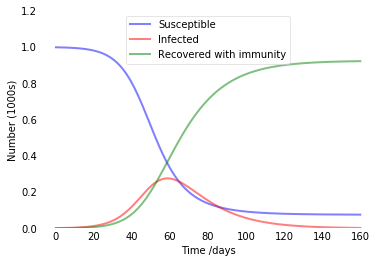

In [43]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./14 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

Take a look at https://github.com/Lewuathe/COVID19-SIR

Also take a look at https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296

https://github.com/closedloop-ai/cv19index

https://github.com/CodeForPhilly/chime

https://github.com/coronafighter/coronaSEIR

Playing with SIR models from "Mathematical Epidemiology" page 23

$$S(t+\Delta t) = S(t) - \beta S(t)I(t)\Delta t$$

$$I(t+\Delta t) = I(t) + \beta S(t)I(t)\Delta t - \gamma I(t)\Delta t$$

$$\mathbf{R}_0 = \frac{\beta N}{\gamma}$$

In [44]:
N = 20_000_000 # Population
γ = 1/14.0 # Recovery rate, meaning that the mean infectious period is 1/γ
R0 = 2.5 # Basic reproduction number
β = R0 * γ / N # Transmission rate per capita
Δt = 0.1 # Time step for the solution method
f = 0.5/100 # fatality rate from number of cases

In [45]:
I = 1
S = N
Is = [I]
Ss = [S]
F0 = 0
Fs = [F0]
ts = np.arange(0,200,Δt)
for t in ts:
    if S < 0:
        S = 0
    if I < 0:
        I = 0
    S_new = S - β * S * I * Δt
    I_new = I + β * S * I * Δt - γ * I * Δt
    S = S_new
    I = I_new
    R = γ * I * Δt
    F0 += f * R
    Fs.append(F0)
    Ss.append(S)
    Is.append(I)
del Ss[-1] # kludge because for loop is not inclusive
del Is[-1]
del Fs[-1]

Text(0.5, 1.0, 'Simple S.I.R. Model\nγ=0.07142857142857142,$R_0$=2.5')

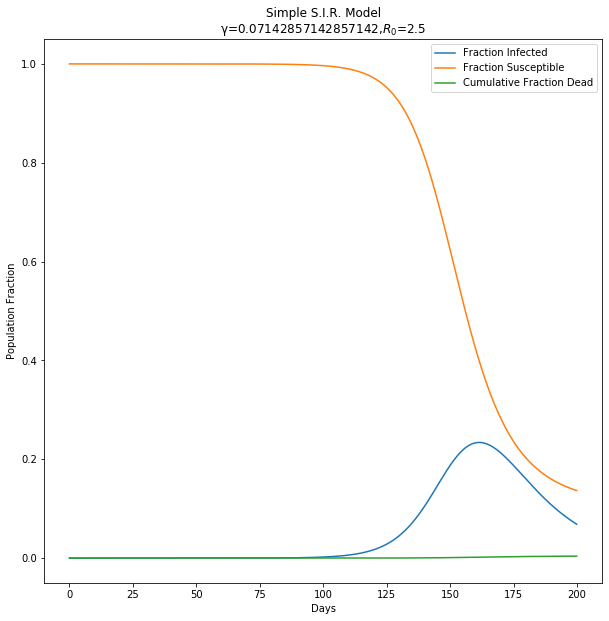

In [46]:
fig,ax = plt.subplots(figsize=(10,10))
sns.lineplot(ts,np.array(Is)/N,ax=ax,label="Fraction Infected")
sns.lineplot(ts,np.array(Ss)/N,ax=ax,label="Fraction Susceptible")
sns.lineplot(ts,np.array(Fs)/N,ax=ax,label="Cumulative Fraction Dead")
ax.legend()
ax.set_xlabel("Days")
ax.set_ylabel("Population Fraction")
ax.set_title(f"Simple S.I.R. Model\nγ={γ},$R_0$={R0}")

In [47]:
F0

79579.60274945182

## Let's set up a Bayesian Parameter Estimator

$$S(t+\Delta t) = S(t) - \beta S(t)I(t)\Delta t$$

$$I(t+\Delta t) = I(t) + \beta S(t)I(t)\Delta t - \gamma I(t)\Delta t$$

$$\mathbf{R}_0 = \frac{\beta N}{\gamma}$$

|Parameter|Interpretation|Value|References|
|---|---|---|---|
|$N$|County Population|2019 Estimate|DHS|
|$N_I$|Initial Infected Population|Fixed|Judgement|
|$\mathbf{R}_0$|Basic Reproduction Number|$\sim N(2.5,\sigma^2=1.5)$|Judgement|
|$\beta$|Transmission Rate Per Capita|$\sim N(1,\sigma^2=1)$|Judgement|
|$\gamma$|Recovery Rate|$\sim N(1,\sigma^2=1)$|Judgement|
|$f$|Fatality Fraction|$\sim N(1,\sigma^2=1)$|Judgement|

In [48]:
def SIR(fips,R0,γ,f,I=10,Δt=0.1,startDate=dt.datetime(year=2020,month=3,day=1),endDate=dt.datetime(year=2020,month=4,day=7)):
    # look up county population
    N = gdf_countyTimeSeriesDiff[gdf_countyTimeSeriesDiff["fips"]==53061]["POPESTIMATE2019"].iloc[0]
    nDays = (endDate-startDate).days
    dates = [startDate + dt.timedelta(days=x) for x in range(nDays)]
    β = R0 * γ / N # Transmission rate per capita
    I = 1
    S = N
    Is = [I]
    Ss = [S]
    F0 = 0
    Fs = [F0]
    ts = np.arange(0,nDays,Δt)
    for t in ts:
        if S < 0:
            S = 0
        if I < 0:
            I = 0
        S_new = S - β * S * I * Δt
        I_new = I + β * S * I * Δt - γ * I * Δt
        S = S_new
        I = I_new
        R = γ * I * Δt
        F0 += f * R
        Fs.append(F0)
        Ss.append(S)
        Is.append(I)
    del Ss[-1] # kludge because for loop is not inclusive
    del Is[-1]
    del Fs[-1]
    df = pd.DataFrame({"date":dates,"I":Is[0::int(1/Δt)],"S":Ss[0::int(1/Δt)],"deaths":Fs[0::int(1/Δt)]})
    df = df.set_index("date")
    return df

In [49]:
df = SIR(53061,3.5,1/16.,0.02,endDate=dt.datetime(year=2020,month=4,day=30))

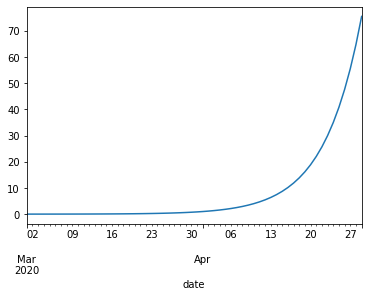

In [50]:
df["deaths"].plot()

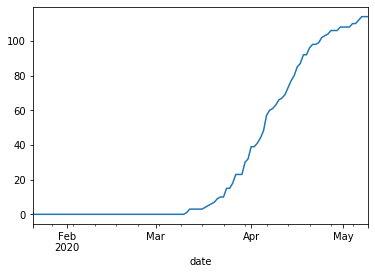

In [51]:
gdf_countyTimeSeriesDiff[gdf_countyTimeSeriesDiff["fips"]==53061].set_index("date")["deaths"].plot()

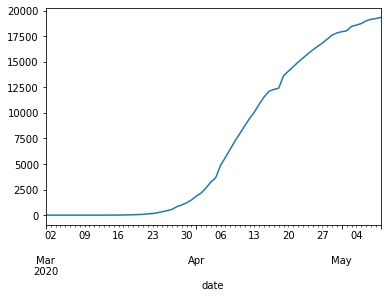

In [52]:
gdf_countyTimeSeriesDiff[gdf_countyTimeSeriesDiff["fips"]==360470].set_index("date")["deaths"].plot()

## Set up the Markov Chain Monte Carlo

In [53]:
def getCountyPopulation(fips=17031):
    return gdf_countyTimeSeriesDiff[gdf_countyTimeSeriesDiff["fips"]==fips]["POPESTIMATE2019"].iloc[0]

In [54]:
def getCountyCOVIDData(fips=17031):
    df = gdf_countyTimeSeriesDiff[gdf_countyTimeSeriesDiff["fips"]==fips].set_index("date")
    return df[["cases","deaths","new cases","new deaths"]]

In [55]:
def plotCountyData(fips=17031,year=2020,month=4,day=11,toPlot="new cases"):
    dateToPlot = dt.datetime(year=2020,month=4,day=6)
    fig,(mapax,lineax) = plt.subplots(1,2,figsize=(50,15),gridspec_kw={'width_ratios': [2, 1]})
    divider = make_axes_locatable(mapax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    filterByDate(gdf_countyTimeSeriesDiff,year=year,month=month,day=day).cx[-125:-50, 20:70].plot(toPlot,ax=mapax,cax=cax,legend="True")
    gdf_USStates.boundary.cx[-125:-50, 20:70].plot(ax=mapax)
    gdf_countyTimeSeriesDiff[gdf_countyTimeSeriesDiff["fips"]==fips].set_index("date")["cases"].plot(ax=lineax,label="Cases")
    gdf_countyTimeSeriesDiff[gdf_countyTimeSeriesDiff["fips"]==fips].set_index("date")["deaths"].plot(ax=lineax,label="Deaths")
    gdf_countyTimeSeriesDiff[gdf_countyTimeSeriesDiff["fips"]==fips].boundary.plot(ax=mapax,color="red")
    mapax.set_title(f"US Cases on {dateToPlot.strftime('%d %B %Y')}")
    lineax.set_title(f"Cases in {gdf_countyTimeSeriesDiff[gdf_countyTimeSeriesDiff['fips']==fips]['NAMELSAD'].iloc[0]}, {gdf_countyTimeSeriesDiff[gdf_countyTimeSeriesDiff['fips']==fips]['state'].iloc[0]}")
    lineax.legend()
    fig.tight_layout()

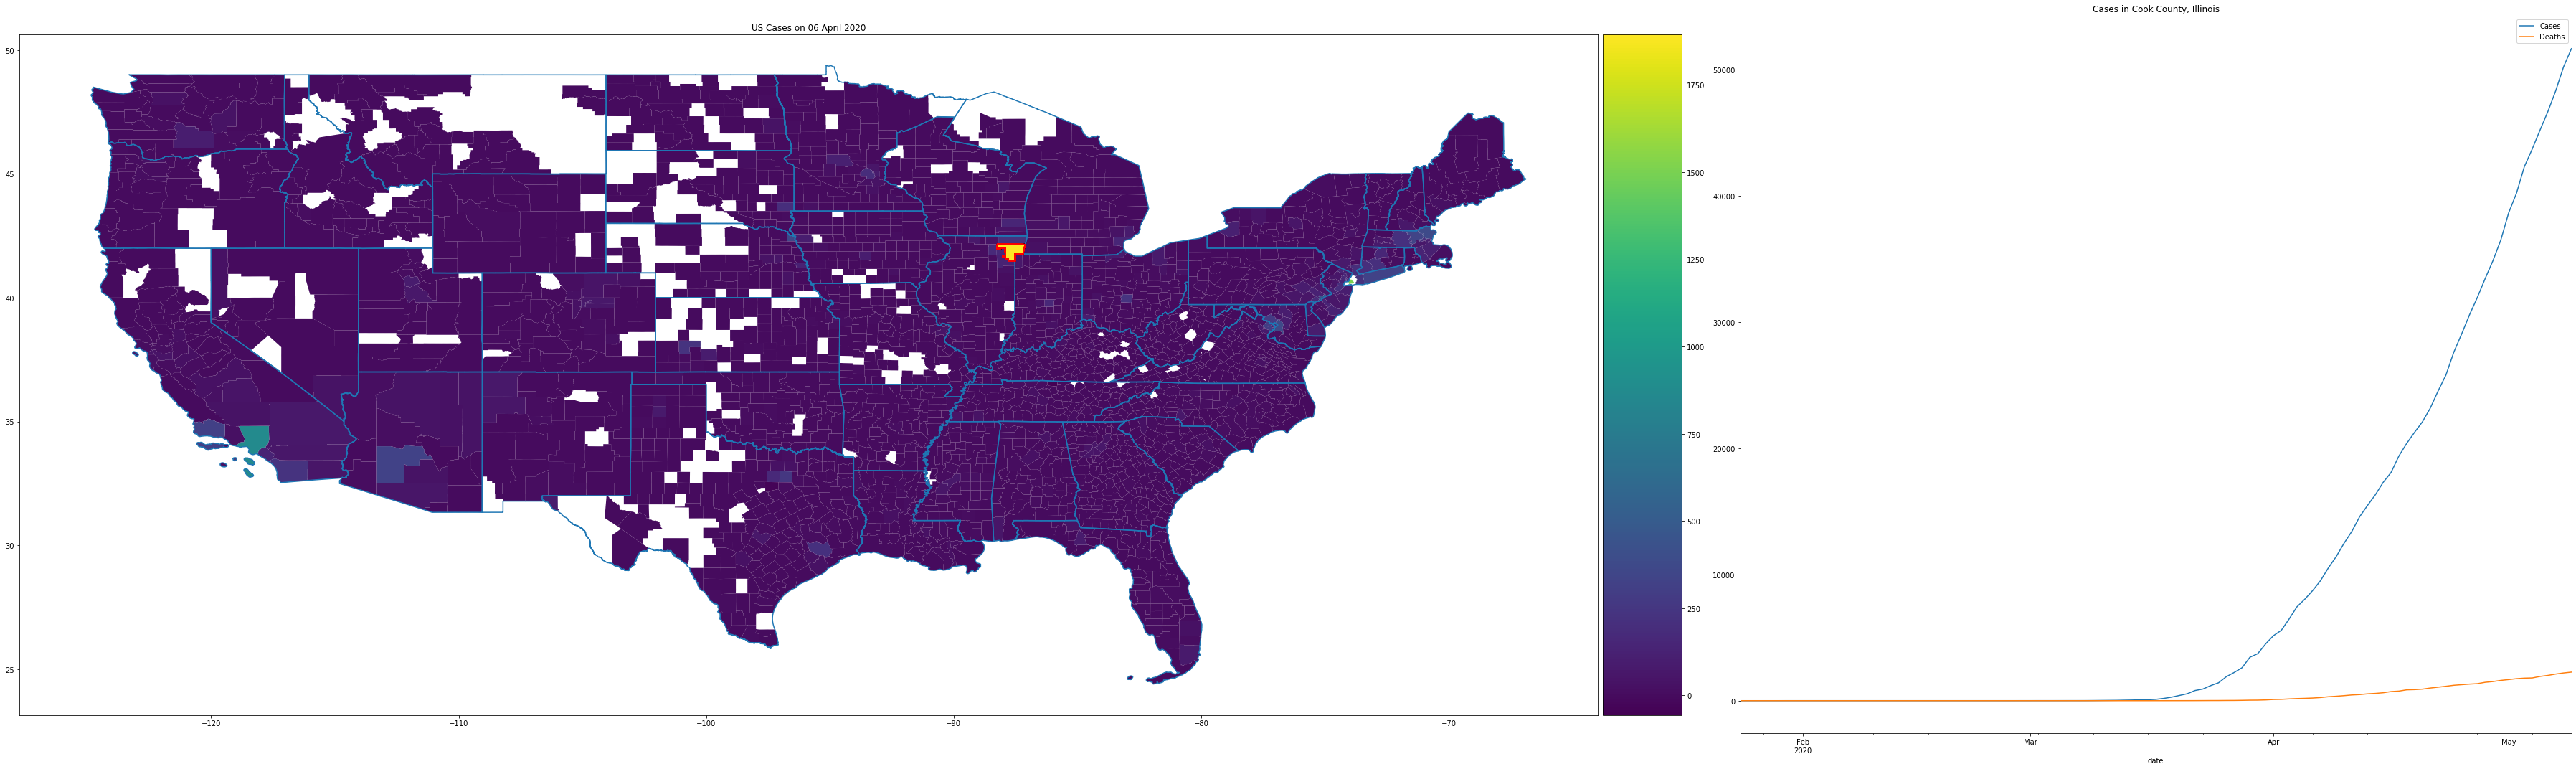

In [57]:
plotCountyData(month=5,day=8)

In [156]:
R0_μ=2.5
R0_σ=2.0
γ_μ=0.07
γ_σ=0.02
f_μ=0.005
f_σ=0.005

In [157]:
# This function generates the random numbers for the parameters being tested
def π(R0_μ=R0_μ,R0_σ=R0_σ,γ_μ=γ_μ,γ_σ=γ_σ,f_μ=f_μ,f_σ=f_σ):
    mean = np.array([R0_μ,γ_μ,f_μ])
    cov = np.diag([R0_σ,γ_σ,f_σ])
    normalDist = stats.multivariate_normal(mean=mean,cov=cov)
    proposedValues = normalDist.rvs()
    return proposedValues

In [158]:
# This function calculates the probability that the parameters are pulled from their distribution
def π_Prior(R0,γ,f,R0_μ=R0_μ,R0_σ=R0_σ,γ_μ=γ_μ,γ_σ=γ_σ,f_μ=f_μ,f_σ=f_σ):
    mean = np.array([R0_μ,γ_μ,f_μ])
    cov = np.diag([R0_σ,γ_σ,f_σ])
    normalDist = stats.multivariate_normal(mean=mean,cov=cov)
    p = normalDist.pdf([R0,γ,f])
    return p

In [149]:
observations =  getCountyCOVIDData()

In [150]:
observations

,cases,deaths,new cases,new deaths
date,,,,
2020-01-24,1,0,0.0,0.0
2020-01-25,1,0,0.0,0.0
2020-01-26,1,0,0.0,0.0
2020-01-27,1,0,0.0,0.0
2020-01-28,1,0,0.0,0.0
...,...,...,...,...
2020-05-05,45223,1922,1508.0,120.0
2020-05-06,46689,2004,1466.0,82.0
2020-05-07,48341,2110,1652.0,106.0


In [62]:
df = SIR(53061,5,1/14.,0.02)

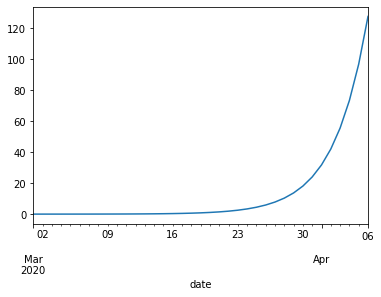

In [63]:
df["deaths"].plot()

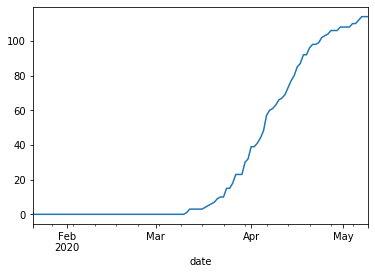

In [64]:
gdf_countyTimeSeriesDiff[gdf_countyTimeSeriesDiff["fips"]==53061].set_index("date")["deaths"].plot()

In [65]:
def predictDeaths(fips,R0,γ,f):
    df = SIR(fips,R0,γ,f)
    return df

In [66]:
# This function calculates the liklihood (non-log) of an indvidual observation
def π_Liklihood(predictedDeaths,date,fips,σ=100):
    return 0

In [67]:
# This function loops through a set of observations and calculates the log liklihood of each, summed
def π_Log_Liklihood(fips,R0,γ,f,startDate=dt.datetime(year=2020,month=3,day=1),endDate=dt.datetime(year=2020,month=4,day=7),σ=1,compareStatistic="deaths"):
    observations =  getCountyCOVIDData(fips)
    logLiklihood = 0.0
    df = SIR(fips,R0,γ,f,startDate=startDate,endDate=endDate)
    for date,row in df.iterrows():
        predictedDeaths = row["deaths"]
        actualDeaths = observations[observations.index==date]["deaths"].iloc[0]
        errorDist = stats.norm(loc=predictedDeaths,scale=σ)
        p = errorDist.pdf(actualDeaths)
        logLiklihood += np.log(p)
    return logLiklihood

In [68]:
def MCMC(fips,n=1000,σ=100):
    # set up
    R0_s = []
    γ_s = []
    f_s = []
    proposed_R0_s = []
    proposed_γ_s = []
    proposed_f_s = []   
    accepted_s = []
    acceptanceRatios = []
    iterations = []
    
    # set a starting point
    R0,γ,f = π()
    
    # pull population and observation data, and set range of dates
    population = getCountyPopulation(fips)
    observations =  getCountyCOVIDData(fips)
    startDate = observations.index[0]
    startDate=dt.datetime(year=2020,month=3,day=15)
    # could try starting obserrvations as when have 10 deaths
    endDate = observations.index[-1]
    
    # loop through the MCMC
    for i in track(range(0,n)):
        iterations.append(i)
        
        # generate a set of proposed values
        proposed_R0,proposed_γ,proposed_f = π()
        proposed_R0_s.append(proposed_R0)
        proposed_γ_s.append(proposed_γ)
        proposed_f_s.append(proposed_f)
        
        # calculate the acceptance probability
        α = np.exp(np.log(π_Prior(proposed_R0,proposed_γ,proposed_f)) + π_Log_Liklihood(fips,proposed_R0,proposed_γ,proposed_f,startDate=startDate,endDate=endDate,σ=σ) - np.log(π_Prior(R0,γ,f)) - π_Log_Liklihood(fips,R0,γ,f,startDate=startDate,endDate=endDate,σ=σ))
        α = min(1.0,α)
        acceptanceRatios.append(α)
        accepted = False
        
        # decide if we accept
        if α == 1: # accept
            R0,γ,f = proposed_R0,proposed_γ,proposed_f
            accepted = True
        else: # draw a rnadom number and take the probability based on α
            rand = np.random.random()
            if rand < α: # accept
                R0,γ,f = proposed_R0,proposed_γ,proposed_f
                accepted = True
        
        # update our iteration
        R0_s.append(R0)
        γ_s.append(γ)
        f_s.append(f)
        accepted_s.append(accepted)
        
    # return
    df = pd.DataFrame({"i":iterations,"R0":R0_s,"γ":γ_s,"f":f_s,
                       "Proposed R0":proposed_R0_s,"Proposed γ":proposed_γ_s,
                       "Proposed f":proposed_f_s,"Accepted":accepted_s,
                       "Acceptance Ratio":acceptanceRatios})
    return df
    

In [69]:
fips = 17031 # cook county

In [70]:
fips = 53061 # Snohomish wa

In [71]:
mcmcresult = MCMC(fips,n=10000)

 [████████████████████████████████████████████████████████████] 10000/10000 [04:53:25<00:00, 1.76s/it]

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

divide by zero encountered in log



In [72]:
mcmcresult

,i,R0,γ,f,Proposed R0,Proposed γ,Proposed f,Accepted,Acceptance Ratio
0,0,4.133168,-0.151750,0.002575,4.133168,-0.151750,0.002575,True,1.000000e+00
1,1,1.262066,0.355732,0.039276,1.262066,0.355732,0.039276,True,1.000000e+00
2,2,1.262066,0.355732,0.039276,4.970071,-0.038876,-0.002339,False,8.281226e-02
3,3,1.262066,0.355732,0.039276,1.889142,0.525660,-0.015261,False,0.000000e+00
4,4,1.262066,0.355732,0.039276,1.923493,0.794239,-0.006513,False,0.000000e+00
...,...,...,...,...,...,...,...,...,...
9995,9995,3.050651,0.408551,0.000139,4.210678,0.037801,-0.048545,False,7.567612e-08
9996,9996,3.050651,0.408551,0.000139,1.543821,0.155809,0.056229,False,1.178783e-06
9997,9997,3.050651,0.408551,0.000139,3.929483,0.025718,0.030795,False,7.966783e-07
9998,9998,3.050651,0.408551,0.000139,2.327333,-0.027491,-0.002969,False,1.481857e-06


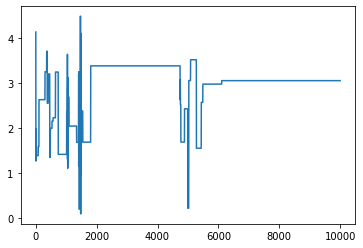

In [73]:
mcmcresult["R0"].plot()

In [132]:
dftest = SIR(fips,1.90,0.057,0.007)

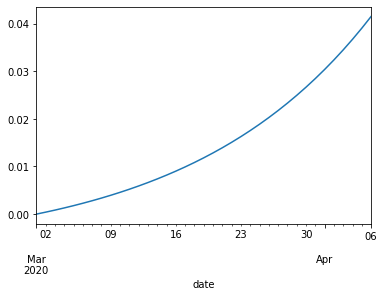

In [133]:
dftest["deaths"].plot()

In [207]:
getCountyCOVIDData(fips)

,cases,deaths,new cases,new deaths
date,,,,
2020-01-24,1,0,0.0,0.0
2020-01-25,1,0,0.0,0.0
2020-01-26,1,0,0.0,0.0
2020-01-27,1,0,0.0,0.0
2020-01-28,1,0,0.0,0.0
...,...,...,...,...
2020-04-29,34880,1516,1431.0,59.0
2020-04-30,36513,1607,1633.0,91.0
2020-05-01,38668,1673,2155.0,66.0


Text(0.5, 1.0, 'f(μ=0.007)')

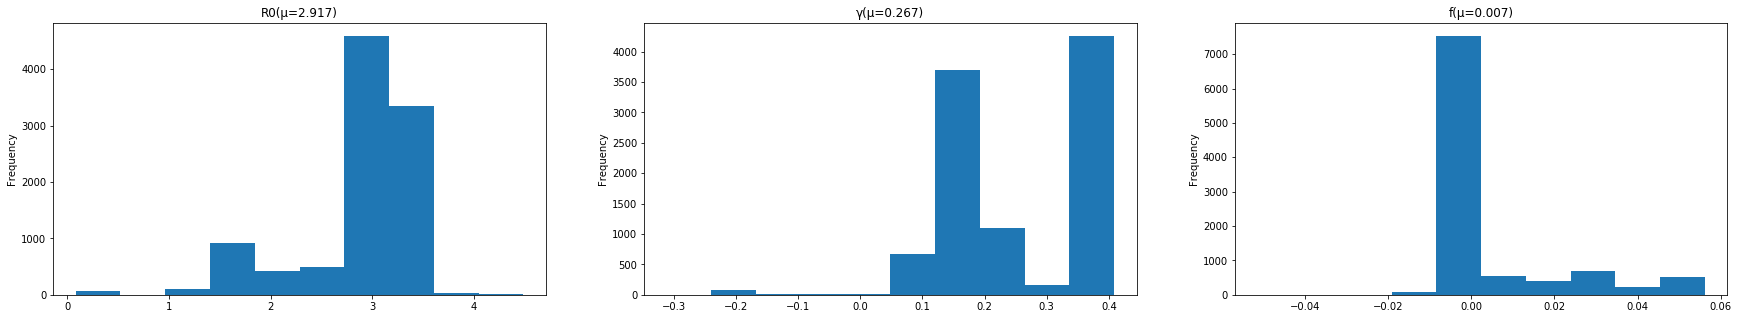

In [74]:
fig, axs = plt.subplots(1,3,figsize=(30,5))
mcmcresult["R0"].plot(kind="hist",ax=axs[0])
mcmcresult["γ"].plot(kind="hist",ax=axs[1])
mcmcresult["f"].plot(kind="hist",ax=axs[2])
axs[0].set_title(f"R0(μ={mcmcresult['R0'].mean():0.3f})")
axs[1].set_title(f"γ(μ={mcmcresult['γ'].mean():0.3f})")
axs[2].set_title(f"f(μ={mcmcresult['f'].mean():0.3f})")

In [75]:
startDate=dt.datetime(year=2020,month=1,day=15)
endDate = dt.datetime(year=2020,month=5,day=3)
dftest = SIR(fips,2.917,0.267,0.007,startDate=startDate,endDate=endDate)

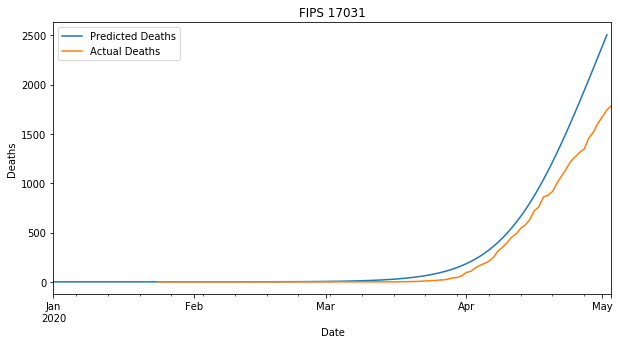

In [221]:
compareResults(fips,4.752,1/30.,0.009)

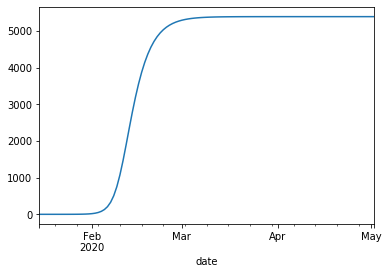

In [76]:
dftest["deaths"].plot()

In [77]:
observations = getCountyCOVIDData(fips)

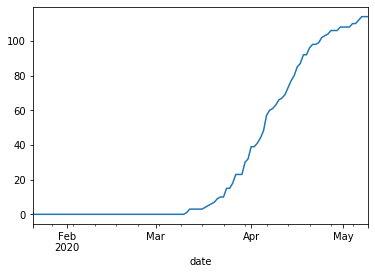

In [78]:
observations["deaths"].plot()

In [80]:
def compareResults(fips,R0,γ,f,startDate=dt.datetime(year=2020,month=1,day=1),endDate=dt.datetime(year=2020,month=5,day=3)):
    dftest = SIR(fips,R0,γ,f,startDate=startDate,endDate=endDate)
    observations = getCountyCOVIDData(fips)
    fig,ax = plt.subplots(figsize=(10,5))
    dftest["deaths"].plot(ax=ax,label="Predicted Deaths")
    observations["deaths"].plot(ax=ax,label="Actual Deaths")
    ax.set_title(f"FIPS {fips}")
    ax.set_ylabel("Deaths")
    ax.set_xlabel("Date")
    ax.legend()

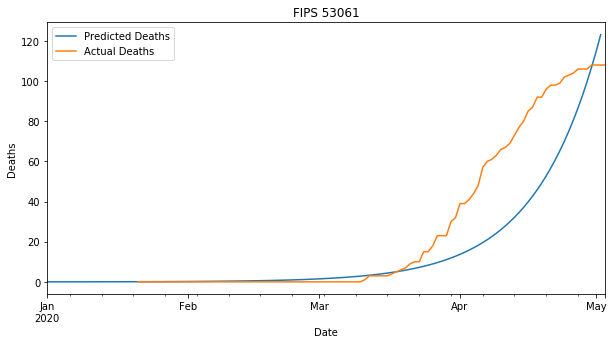

In [186]:
compareResults(fips,2.0,1/14.0,0.021)

### Try applying other methods

In [190]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pytest
import chaospy as cp
import pandas as pd

In [191]:
"""
Takes the dataframe representation of coefficients and variable orders and allows this to be treated like
an equation, taking inputs and returning the evaluation.  Very simple but I think a pretty clean
way to represent the models used in task three. Most importantly, makes it much easier to evaluate
ChaosPy polynomials in my opinion.

Inputs:
coefsDF (Pandas DataFrame) -> a data structure I created for this assignment where the first column
                              is the coefficient of each term, and each subsequent numbered column
                              is a variable index
varsArray (list or numpy array) -> the coordinates at which the function is being evaluated

Returns:
valueToReturn (float) -> The value of the function represented by coefsDF at the coordinates represented
                        by varsArray
"""
def matrixToEquation(coefsDF,varsArray):
    valueToReturn = 0.0
    for i,row in coefsDF.iterrows():
        rowValue = row["Coefficient"]
        for j,var in enumerate(varsArray):
            rowValue *= np.power(var,row[j])
        valueToReturn += rowValue
    return valueToReturn

In [192]:
# this is kludgy, but pass the two coefficinent matrices and an array of variables where
# the place which is (min,max) is the study (non-fixed) variable and the other values are fixed
def plotComparison(correctCoefs,generatedCoefs,arr,title='',nSamples=100):
    correctEvaluations = []
    generatedEvaluations = []
    indexOfVariable = [i for i in range(len(arr)) if type(arr[i]) == tuple][0]
    lowerBound = arr[indexOfVariable][0]
    upperBound = arr[indexOfVariable][1]
    varValues = np.linspace(lowerBound,upperBound,nSamples)
    for varValue in varValues:
        variableInput = []
        for varLoc,varVal in enumerate(arr):
            if varLoc == indexOfVariable:
                variableInput.append(varValue)
            else:
                variableInput.append(varVal)
        correctEvaluation = matrixToEquation(correctCoefs,variableInput)
        generatedEvaluation = matrixToEquation(generatedCoefs,variableInput)
        correctEvaluations.append(correctEvaluation)
        generatedEvaluations.append(generatedEvaluation)
    fig,ax = plt.subplots(figsize=(10,5))
    ax.plot(varValues,correctEvaluations,label="Correct")
    ax.scatter(varValues,generatedEvaluations,label="Test",marker="*",color="red",alpha=0.5)
    ax.set_title(title)
    ax.legend()

In [193]:
"""
Creates a pretty-print string representation of the polynomial represented by the pandas dataframe,
written to look nice in LaTex.  The cutoff will drop (from printing, not from analyzing) any coefficient
with an absolute value less than the cutoff.  Coefficients are rounded for printing based upon rounding.
"""
def convertDFGeneratedToEquation(df_Generated,variableName="X",cutoff=0.001,rounding=3):
    df_Generated_Filtered = df_Generated[np.abs(df_Generated["Coefficient"]) >= 0.001]
    variables = list(df_Generated.columns)[1:]
    strRepresentation = ""
    for i,row in df_Generated_Filtered.iterrows():
        if row["Coefficient"] >= 0:
            term = f"+{round(row['Coefficient'],rounding)}"
        else:
            term = f"{round(row['Coefficient'],rounding)}"
        for variable in variables:
            if row[variable] != 0:
                term += f"{variableName}_{variable+1}^{int(row[variable])}" # the variable + 1 is to be congruent with the 1-based indexing of the assignment
        strRepresentation += term
    return strRepresentation

In [194]:
"""
This function implements task three directly, with the examples below demonstrating how it can be
used to implement tasks one and two.  

Inputs:
distribution (Pandas DataFrame) -> a data structure I created for this assignment where the first column
                              is the coefficient of each term, and each subsequent numbered column
                              is a variable index
            
simulationDistribution (Pandas DataFrame) -> The same data structure as above to represent the polynomials
                                             being modeled.  Please note that it is very easy to replace this
                                             with an actual simulation, or any generator of choice.
                                        
order (int) -> The order to be evaluated.  As noted in the discussion, order < 2 produces unpredictable results

sampleRule (string) -> The polynomial type, including "gaussian", "gauss_legendre"

Returns:
df_Generated (Pandas DataFrame) -> a data structure I created for this assignment where the first column
                              is the coefficient of each term, and each subsequent numbered column
                              is a variable index
"""
def generatePolynomialSurrogate(distribution,simulationDistribution,order,sampleRule="gauss_legendre"):
    orthogonal_expansion = cp.orth_ttr(order, distribution)
    samples,weights = cp.generate_quadrature(order,distribution,rule=sampleRule)
    solves = np.array([matrixToEquation(simulationDistribution,sample) for sample in samples.T])
    approx_model = cp.fit_regression(orthogonal_expansion, samples, solves)
    nVars = approx_model.exponents.shape[1]
    dataDict = {'Coefficient':approx_model.coefficients}
    for varIndex in range(0,nVars):
        dataDict[varIndex] = approx_model.exponents[:,varIndex]
    df_Generated = pd.DataFrame(dataDict)
    return df_Generated

In [196]:
distribution_x = cp.J(cp.Normal(2.5,2.0),cp.Normal(0.1,0.05),cp.Normal(0.005,0.001))

In [ ]:
# This function generates the random numbers for the parameters being tested
def π(R0_μ=2.5,R0_σ=2.0,γ_μ=0.1,γ_σ=0.05,f_μ=0.005,f_σ=0.001):
    mean = np.array([R0_μ,γ_μ,f_μ])
    cov = np.diag([R0_σ,γ_σ,f_σ])
    normalDist = stats.multivariate_normal(mean=mean,cov=cov)
    proposedValues = normalDist.rvs()
    return proposedValues

In [201]:
R0s = []
γs = []
fs = []
R0_μ=2.5
R0_σ=2.0
γ_μ=0.1
γ_σ=0.1
f_μ=0.02
f_σ=0.01
mean = np.array([R0_μ,γ_μ,f_μ])
cov = np.diag([R0_σ,γ_σ,f_σ])
normalDist = stats.multivariate_normal(mean=mean,cov=cov)
for i in range(0,1000):
    R0,γ,f = normalDist.rvs()
    R0s.append(R0)
    γs.append(γ)
    fs.append(f)
dfSimple = pd.DataFrame({"R0":R0s,"γ":γs,"f":fs})

Text(0.5, 1.0, 'f(μ=0.023)')

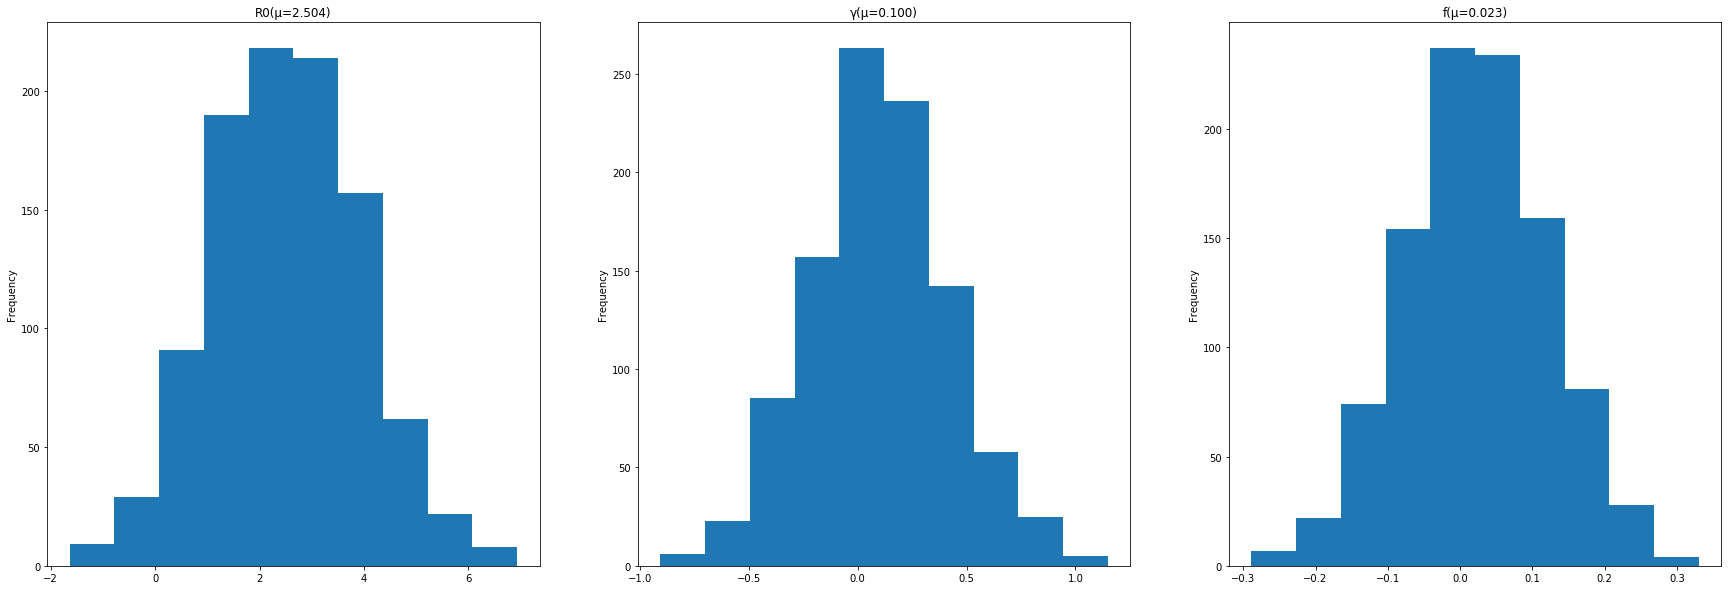

In [235]:
fig, axs = plt.subplots(1,3,figsize=(30,10))
dfSimple["R0"].plot(kind="hist",ax=axs[0])
dfSimple["γ"].plot(kind="hist",ax=axs[1])
dfSimple["f"].plot(kind="hist",ax=axs[2])
axs[0].set_title(f"R0(μ={dfSimple['R0'].mean():0.3f})")
axs[1].set_title(f"γ(μ={dfSimple['γ'].mean():0.3f})")
axs[2].set_title(f"f(μ={dfSimple['f'].mean():0.3f})")

In [ ]:
def compareResults(fips,R0,γ,f,startDate=dt.datetime(year=2020,month=1,day=1),endDate=dt.datetime(year=2020,month=5,day=3)):
    dftest = SIR(fips,R0,γ,f,startDate=startDate,endDate=endDate)
    observations = getCountyCOVIDData(fips)
    fig,ax = plt.subplots(figsize=(10,5))
    dftest["deaths"].plot(ax=ax,label="Predicted Deaths")
    observations["deaths"].plot(ax=ax,label="Actual Deaths")
    ax.set_title(f"FIPS {fips}")
    ax.set_ylabel("Deaths")
    ax.set_xlabel("Date")
    ax.legend()

In [ ]:
compareResults(fips,4.752,1/30.,0.009)

In [222]:
fips

17031

In [162]:
def plotCountyDataWithComparison(fips=17031,R0=4.572,γ=1/30.,f=0.009,year=2020,month=5,day=3,toPlot="new cases"):
    startDate=dt.datetime(year=2020,month=1,day=1)
    endDate=dt.datetime(year=2020,month=5,day=3)
    
    dateToPlot = dt.datetime(year=2020,month=4,day=6)
    fig,(mapax,lineax) = plt.subplots(1,2,figsize=(50,15),gridspec_kw={'width_ratios': [2, 1]})
    divider = make_axes_locatable(mapax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    filterByDate(gdf_countyTimeSeriesDiff,year=year,month=month,day=day).cx[-125:-50, 20:70].plot(toPlot,ax=mapax,cax=cax,legend="True")
    gdf_USStates.boundary.cx[-125:-50, 20:70].plot(ax=mapax)
    
    dftest = SIR(fips,R0,γ,f,startDate=startDate,endDate=endDate)
    observations = getCountyCOVIDData(fips)
    dftest["deaths"].plot(ax=lineax,label="Predicted Deaths")
    observations["deaths"].plot(ax=lineax,label="Actual Deaths")
    lineax.set_title(f"FIPS {fips}")
    lineax.set_ylabel("Deaths")
    lineax.set_xlabel("Date")
    lineax.legend( prop={"size":200})
    
#     gdf_countyTimeSeriesDiff[gdf_countyTimeSeriesDiff["fips"]==fips].set_index("date")["cases"].plot(ax=lineax,label="Cases")
#     gdf_countyTimeSeriesDiff[gdf_countyTimeSeriesDiff["fips"]==fips].set_index("date")["deaths"].plot(ax=lineax,label="Deaths")
    gdf_countyTimeSeriesDiff[gdf_countyTimeSeriesDiff["fips"]==fips].boundary.plot(ax=mapax,color="red")
    
    
    mapax.set_title(f"US Cases on {dateToPlot.strftime('%d %B %Y')}")
    lineax.set_title(f"Cases in {gdf_countyTimeSeriesDiff[gdf_countyTimeSeriesDiff['fips']==fips]['NAMELSAD'].iloc[0]}, {gdf_countyTimeSeriesDiff[gdf_countyTimeSeriesDiff['fips']==fips]['state'].iloc[0]}")
    lineax.legend()
    fig.tight_layout()

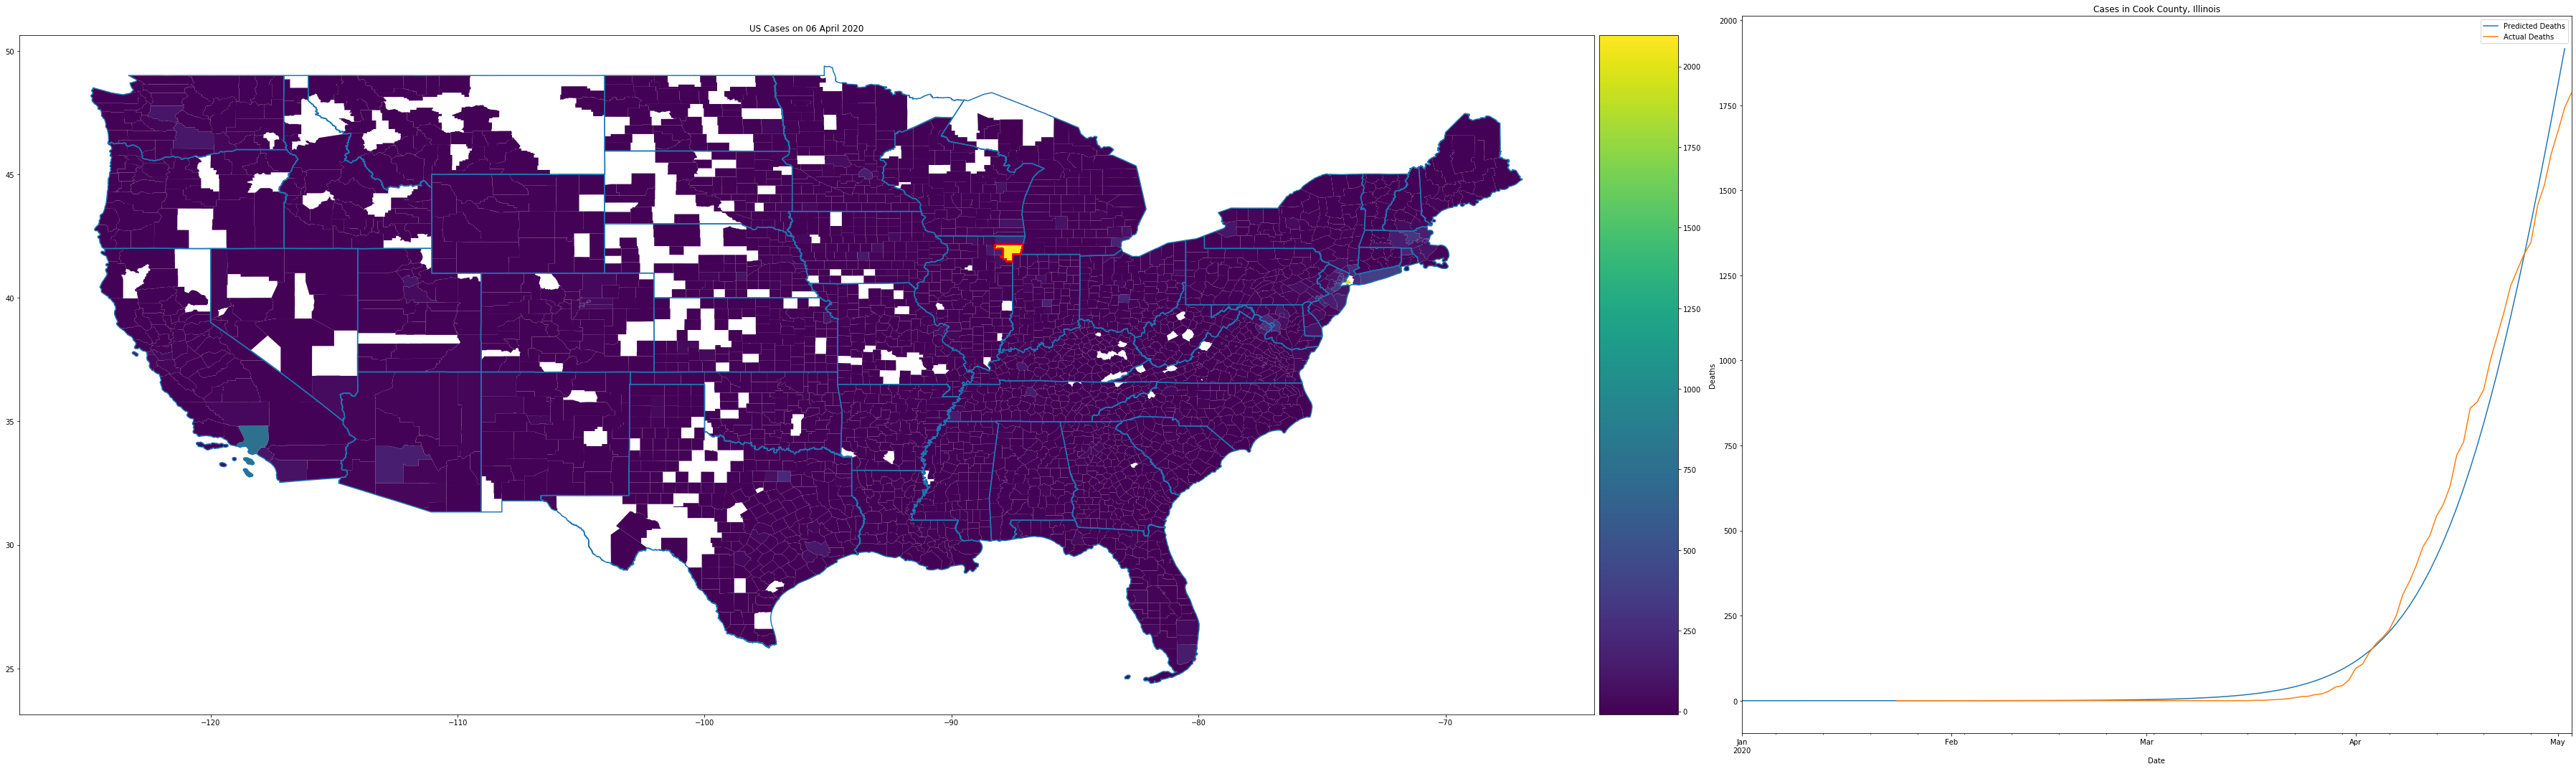

In [250]:
plotCountyDataWithComparison()

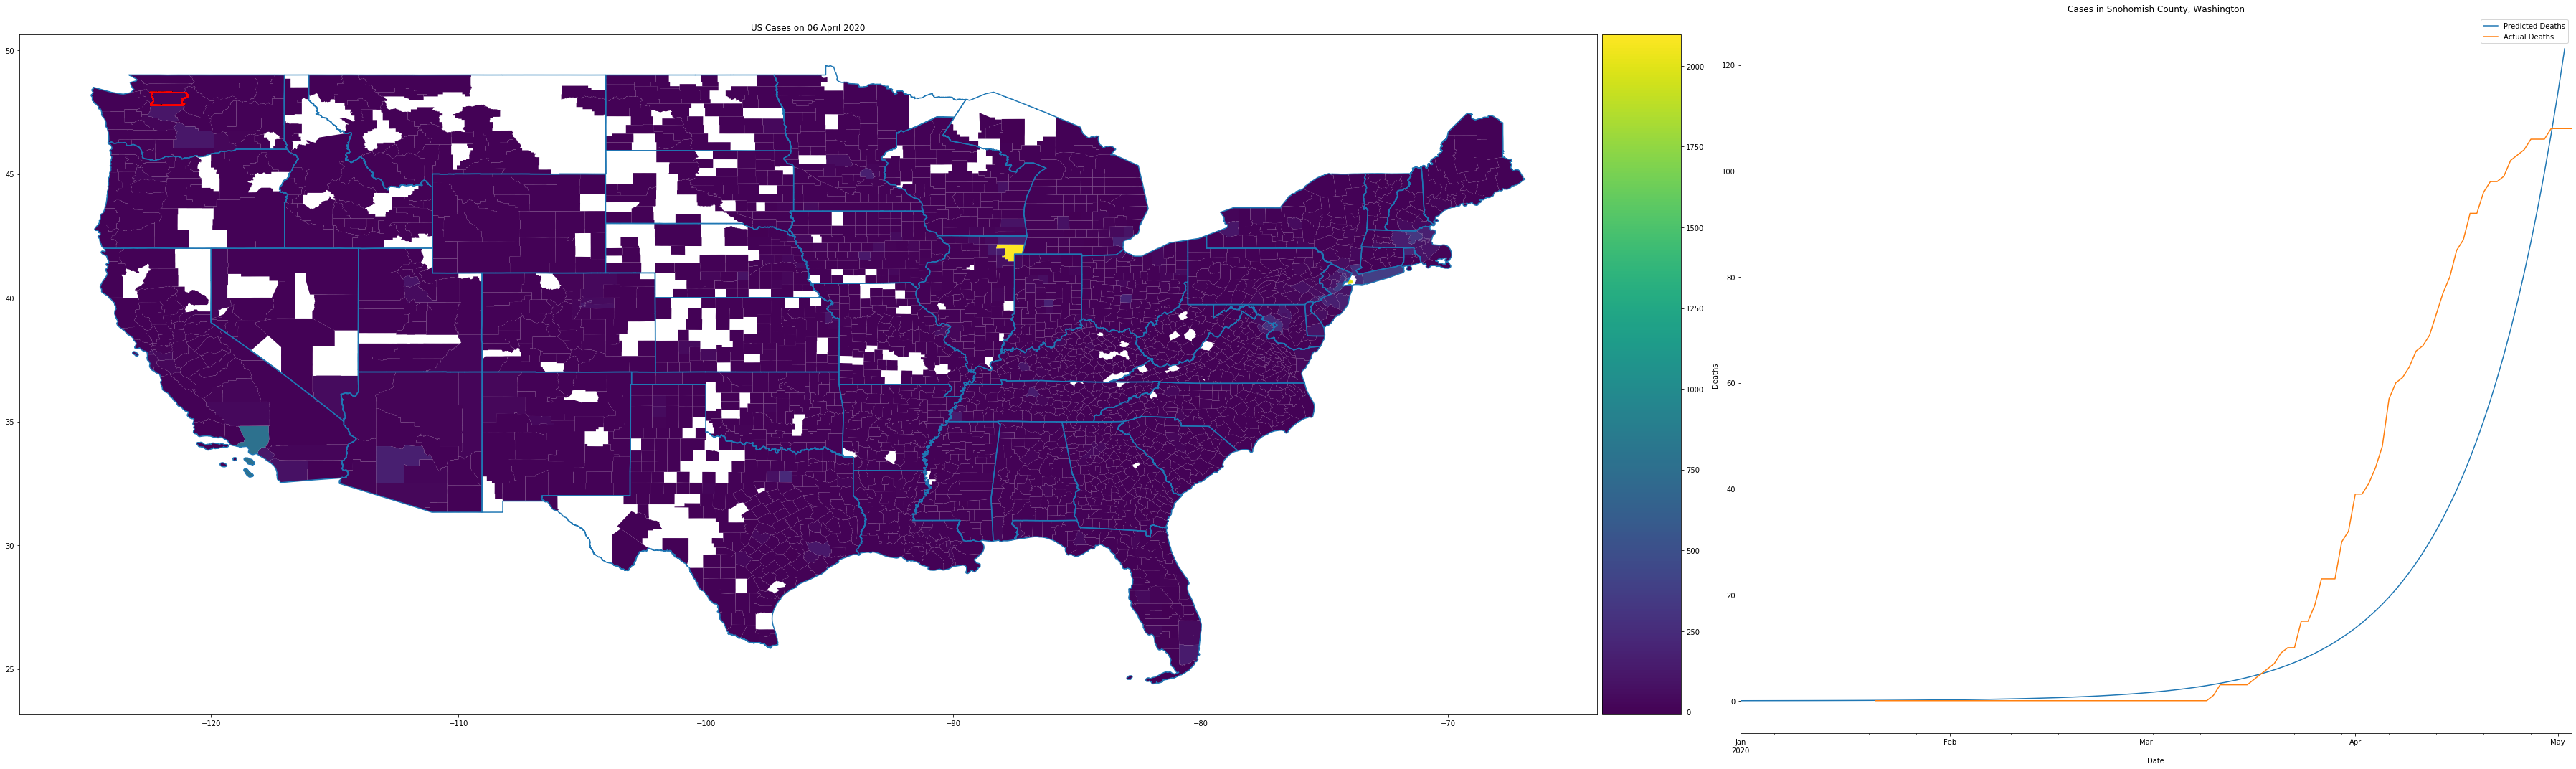

In [230]:
plotCountyDataWithComparison(53061,2.0,1/14.0,0.021)

## Producing some figures for the report

In [135]:
FIPS_Snohomish = 53061
FIPS_Cook = 17031
FIPS_Champaign = 17019
FIPS_Suffolk = 36103
FIPS_Johnson = 20091
FIPS_Cumberland = 37051
FIPS_Durham = 37063

In [137]:
dict_comparison = {"Cook County":FIPS_Cook,"Champaign County":FIPS_Champaign,"Durham County":FIPS_Durham,"Cumberland County":FIPS_Cumberland}

In [142]:
dict_comparison.values()

dict_values([17031, 17019, 37063, 37051])

In [183]:
R0_μ=4.5
R0_σ=1.0
γ_μ=0.01
γ_σ=0.005
f_μ=0.001
f_σ=0.001

In [187]:
mcmcresult = MCMC(dict_comparison["Cook County"],n=1000)

 [████████████████████████████████████████████████████████████] 1000/1000 [02:54<00:00, 0.17s/it]

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning:

divide by zero encountered in log

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning:

overflow encountered in exp



Text(0.5, 1.0, 'f(μ=0.016)')

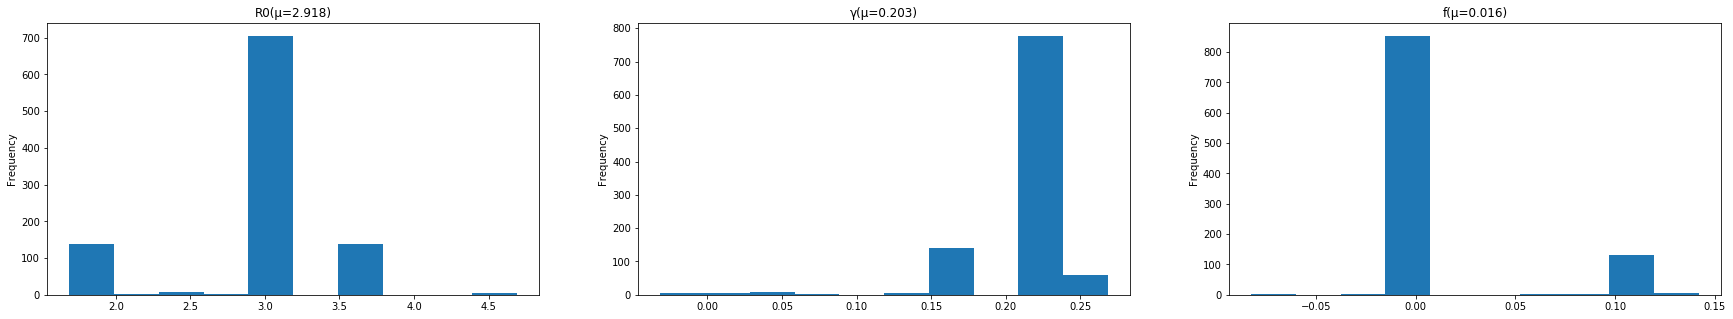

In [188]:
fig, axs = plt.subplots(1,3,figsize=(30,5))
mcmcresult["R0"].plot(kind="hist",ax=axs[0])
mcmcresult["γ"].plot(kind="hist",ax=axs[1])
mcmcresult["f"].plot(kind="hist",ax=axs[2])
axs[0].set_title(f"R0(μ={mcmcresult['R0'].mean():0.3f})")
axs[1].set_title(f"γ(μ={mcmcresult['γ'].mean():0.3f})")
axs[2].set_title(f"f(μ={mcmcresult['f'].mean():0.3f})")

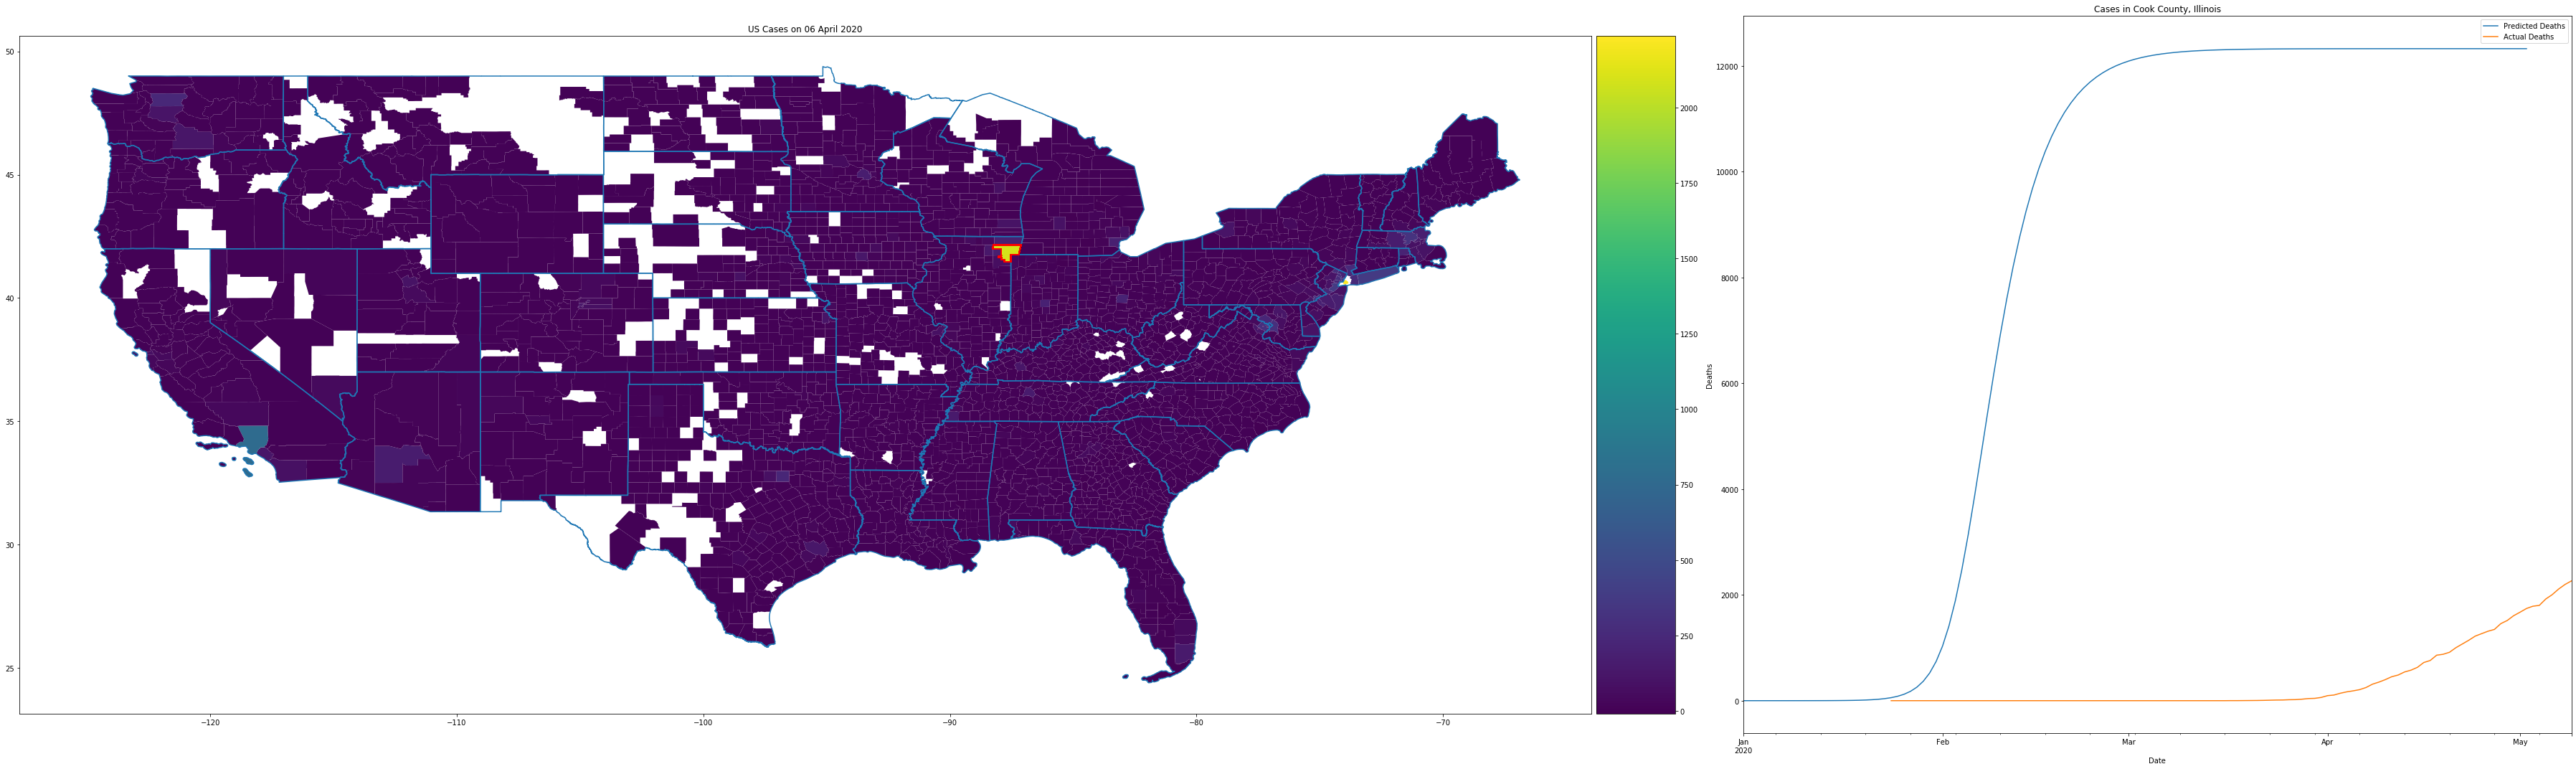

In [189]:
plotCountyDataWithComparison(dict_comparison["Cook County"],mcmcresult['R0'].mean(),mcmcresult['γ'].mean(),mcmcresult['f'].mean())

## Let's try polynomial expansion too!

In [109]:
"""
Takes the dataframe representation of coefficients and variable orders and allows this to be treated like
an equation, taking inputs and returning the evaluation.  Very simple but I think a pretty clean
way to represent the models used in task three. Most importantly, makes it much easier to evaluate
ChaosPy polynomials in my opinion.

Inputs:
coefsDF (Pandas DataFrame) -> a data structure I created for this assignment where the first column
                              is the coefficient of each term, and each subsequent numbered column
                              is a variable index
varsArray (list or numpy array) -> the coordinates at which the function is being evaluated

Returns:
valueToReturn (float) -> The value of the function represented by coefsDF at the coordinates represented
                        by varsArray
"""
def matrixToEquation(coefsDF,varsArray):
    valueToReturn = 0.0
    for i,row in coefsDF.iterrows():
        rowValue = row["Coefficient"]
        for j,var in enumerate(varsArray):
            rowValue *= np.power(var,row[j])
        valueToReturn += rowValue
    return valueToReturn

In [110]:
"""
This function implements task three directly, with the examples below demonstrating how it can be
used to implement tasks one and two.  

Inputs:
distribution (Pandas DataFrame) -> a data structure I created for this assignment where the first column
                              is the coefficient of each term, and each subsequent numbered column
                              is a variable index
            
simulationDistribution (Pandas DataFrame) -> The same data structure as above to represent the polynomials
                                             being modeled.  Please note that it is very easy to replace this
                                             with an actual simulation, or any generator of choice.
                                        
order (int) -> The order to be evaluated.  As noted in the discussion, order < 2 produces unpredictable results

sampleRule (string) -> The polynomial type, including "gaussian", "gauss_legendre"

Returns:
df_Generated (Pandas DataFrame) -> a data structure I created for this assignment where the first column
                              is the coefficient of each term, and each subsequent numbered column
                              is a variable index
"""
def generatePolynomialSurrogate(distribution,simulationDistribution,order,sampleRule="gauss_legendre"):
    orthogonal_expansion = cp.orth_ttr(order, distribution)
    samples,weights = cp.generate_quadrature(order,distribution,rule=sampleRule)
    solves = np.array([matrixToEquation(simulationDistribution,sample) for sample in samples.T])
    approx_model = cp.fit_regression(orthogonal_expansion, samples, solves)
    nVars = approx_model.exponents.shape[1]
    dataDict = {'Coefficient':approx_model.coefficients}
    for varIndex in range(0,nVars):
        dataDict[varIndex] = approx_model.exponents[:,varIndex]
    df_Generated = pd.DataFrame(dataDict)
    return df_Generated

In [112]:
R0_μ=2.5
R0_σ=2.0
γ_μ=0.1
γ_σ=0.05
f_μ=0.005
f_σ=0.001

In [113]:
distribution_x = cp.J(cp.Normal(R0_μ,R0_σ),cp.Normal(γ_μ,γ_σ),cp.Normal(f_μ,f_σ))

In [114]:
observations

,cases,deaths,new cases,new deaths
date,,,,
2020-01-21,1,0,0.0,0.0
2020-01-22,1,0,0.0,0.0
2020-01-23,1,0,0.0,0.0
2020-01-24,1,0,0.0,0.0
2020-01-25,1,0,0.0,0.0
...,...,...,...,...
2020-05-05,2807,110,23.0,0.0
2020-05-06,2830,112,23.0,2.0
2020-05-07,2889,114,59.0,2.0


In [132]:
polyfitarr = np.polyfit(range(0,110),np.array(observations["deaths"]),3)

In [133]:
def polyFitToPlot(polyfitarr,arrrange):
    results = []
    power = len(polyfitarr) - 1
    for i in range(0,arrrange):
        tempResult = 0.0
        tempPower = power
        for j,value in enumerate(polyfitarr):
            tempResult += i * np.power(value,tempPower)
            tempPower -= 1
        results.append(tempResult)
    plt.plot(range(0,arrrange),results)
    return results

[0.0,
 -0.5058531496605942,
 -1.0117062993211885,
 -1.5175594489817819,
 -2.023412598642377,
 -2.5292657483029712,
 -3.0351188979635637,
 -3.540972047624159,
 -4.046825197284754,
 -4.552678346945347,
 -5.0585314966059425,
 -5.564384646266536,
 -6.070237795927127,
 -6.576090945587723,
 -7.081944095248318,
 -7.587797244908913,
 -8.093650394569508,
 -8.5995035442301,
 -9.105356693890695,
 -9.61120984355129,
 -10.117062993211885,
 -10.62291614287248,
 -11.128769292533072,
 -11.634622442193667,
 -12.140475591854255,
 -12.64632874151485,
 -13.152181891175445,
 -13.65803504083604,
 -14.163888190496635,
 -14.66974134015723,
 -15.175594489817826,
 -15.68144763947842,
 -16.187300789139016,
 -16.693153938799604,
 -17.1990070884602,
 -17.704860238120794,
 -18.21071338778139,
 -18.716566537441985,
 -19.22241968710258,
 -19.728272836763175,
 -20.23412598642377,
 -20.739979136084365,
 -21.24583228574496,
 -21.751685435405548,
 -22.257538585066143,
 -22.76339173472674,
 -23.269244884387334,
 -23.77509

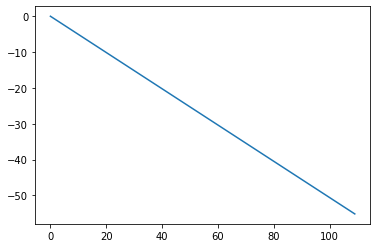

In [134]:
polyFitToPlot(polyfitarr,110)